[*********************100%***********************]  10 of 10 completed


Portfolio Metrics:


,Method,Mean Return,Standard Deviation,VaR at 90%,ES at 90%,VaR at 95%,ES at 95%,VaR at 99%,ES at 99%
0,equal_weight,0.003113,0.016126,-0.018487,-0.024836,-0.022705,-0.02929,-0.032298,-0.037024
1,min_variance,0.001942,0.011962,-0.012643,-0.018495,-0.016459,-0.02225,-0.026792,-0.027930
2,max_sharpe_ratio,0.004127,0.018805,-0.017349,-0.025165,-0.024576,-0.02981,-0.035213,-0.036514



Portfolio Weights:


,AAPL,MSFT,GOOGL,AMZN,TSLA,META,NFLX,NVDA,AMD,INTC
equal_weight,0.100000,1.000000e-01,1.000000e-01,1.000000e-01,0.100000,1.000000e-01,1.000000e-01,0.100000,0.100000,1.000000e-01
min_variance,0.659089,0.000000e+00,2.188832e-03,1.898108e-02,0.054091,2.818926e-18,2.423163e-01,0.023333,0.000000,2.168404e-18
max_sharpe_ratio,0.137898,3.740497e-18,3.848918e-18,8.456777e-18,0.174840,3.338855e-01,5.990217e-18,0.001628,0.316489,3.525991e-02


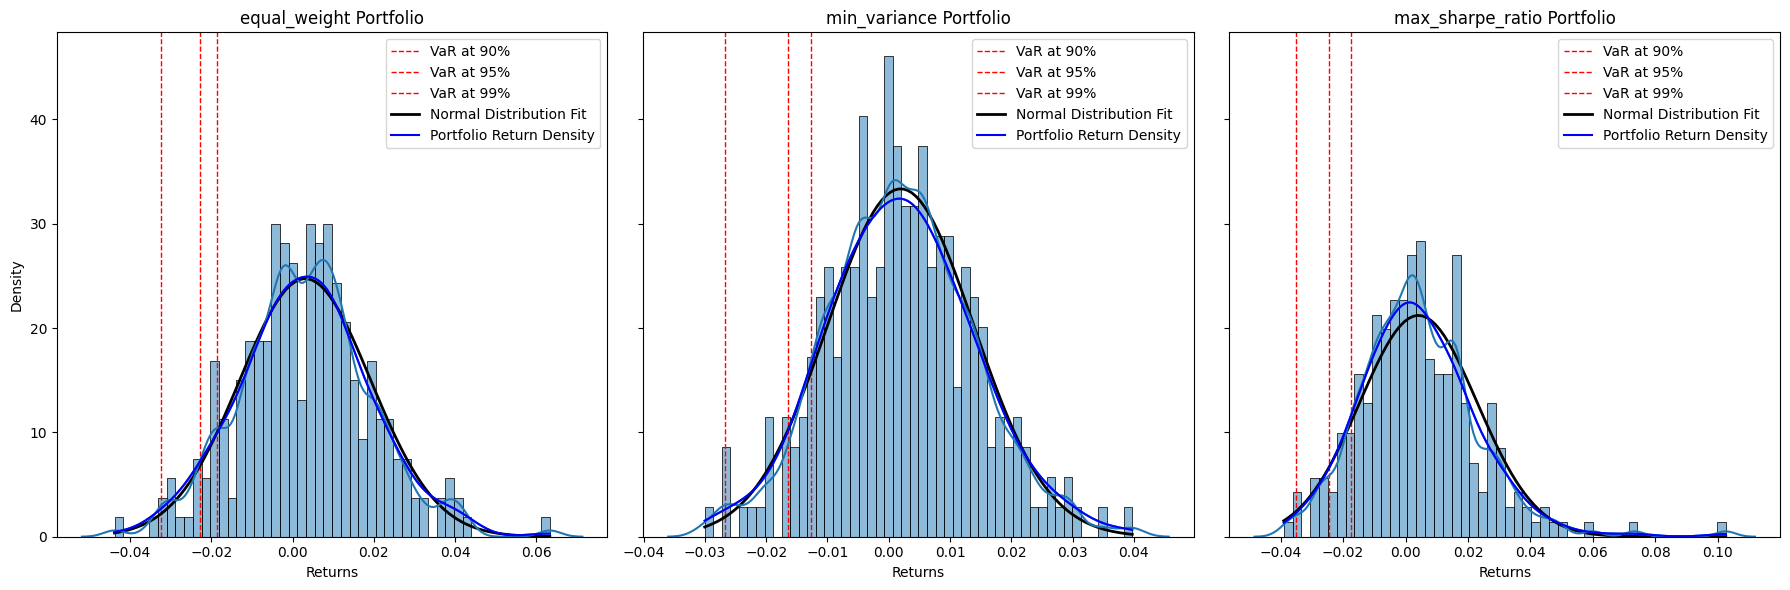

In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from scipy.optimize import minimize

# Define portfolio stocks and weights
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NFLX', 'NVDA', 'AMD', 'INTC']  # Expanded list of stock symbols

# Download historical data
def get_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    return data['Adj Close']

# Calculate daily returns
def calculate_returns(data):
    returns = data.pct_change().dropna()
    return returns

# Calculate portfolio returns
def calculate_portfolio_returns(returns, weights):
    portfolio_returns = returns.dot(weights)
    return portfolio_returns

# Calculate VaR
def calculate_var(returns, confidence_level=0.95):
    sorted_returns = returns.sort_values()
    index = int((1 - confidence_level) * len(sorted_returns))
    var_value = sorted_returns.iloc[index]
    return var_value

# Calculate Expected Shortfall (ES)
def calculate_es(returns, confidence_level=0.95):
    var_value = calculate_var(returns, confidence_level)
    es = returns[returns <= var_value].mean()
    return es

# Define parameters
start_date = '2023-01-01'
end_date = '2024-01-01'
confidence_levels = [0.90, 0.95, 0.99]  # Different confidence levels

# Get stock data
data = get_stock_data(stocks, start_date, end_date)

# Calculate returns
returns = calculate_returns(data)

# Portfolio optimization functions
def portfolio_performance(weights, returns):
    portfolio_returns = calculate_portfolio_returns(returns, weights)
    return portfolio_returns.mean(), portfolio_returns.std()

def min_variance(weights, returns):
    _, std_dev = portfolio_performance(weights, returns)
    return std_dev

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.0):
    mean, std_dev = portfolio_performance(weights, returns)
    return -(mean - risk_free_rate) / std_dev

def optimize_portfolio(returns, method='min_variance'):
    num_assets = len(returns.columns)
    initial_weights = np.array(num_assets * [1. / num_assets])

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))

    if method == 'min_variance':
        result = minimize(min_variance, initial_weights, args=(returns,), method='SLSQP', bounds=bounds, constraints=constraints)
    elif method == 'max_sharpe_ratio':
        result = minimize(negative_sharpe_ratio, initial_weights, args=(returns,), method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

# Optimize portfolios
methods = ['equal_weight', 'min_variance', 'max_sharpe_ratio']
portfolio_metrics = []
portfolio_weights = []

for method in methods:
    if method == 'equal_weight':
        weights = np.array(len(stocks) * [1. / len(stocks)])
    else:
        weights = optimize_portfolio(returns, method=method)

    portfolio_returns = calculate_portfolio_returns(returns, weights)

    mean_return = portfolio_returns.mean()
    std_dev = portfolio_returns.std()
    metrics = {'Method': method,
               'Mean Return': mean_return,
               'Standard Deviation': std_dev}

    for cl in confidence_levels:
        var_value = calculate_var(portfolio_returns, cl)
        es_value = calculate_es(portfolio_returns, cl)
        metrics[f'VaR at {int(cl*100)}%'] = var_value
        metrics[f'ES at {int(cl*100)}%'] = es_value

    portfolio_metrics.append(metrics)
    portfolio_weights.append(weights)

# Convert metrics and weights to DataFrames
metrics_df = pd.DataFrame(portfolio_metrics)
weights_df = pd.DataFrame(portfolio_weights, columns=stocks, index=methods)

# Print DataFrames
print("Portfolio Metrics:")
display(metrics_df)
print("\nPortfolio Weights:")
display(weights_df)

# Plot portfolio returns distributions in subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

optimized_portfolios = {
    'equal_weight': calculate_portfolio_returns(returns, portfolio_weights[0]),
    'min_variance': calculate_portfolio_returns(returns, portfolio_weights[1]),
    'max_sharpe_ratio': calculate_portfolio_returns(returns, portfolio_weights[2])
}

for i, (method, returns) in enumerate(optimized_portfolios.items()):
    ax = axs[i]
    sns.histplot(returns, bins=50, kde=True, ax=ax, edgecolor='k', stat='density')

    # Plot VaR lines for each portfolio
    for cl in confidence_levels:
        var_value = calculate_var(returns, cl)
        ax.axvline(var_value, color='r', linestyle='dashed', linewidth=1, label=f'VaR at {int(cl*100)}%')

    # Plot normal distribution
    mean = returns.mean()
    std_dev = returns.std()
    xmin, xmax = returns.min(), returns.max()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean, std_dev)
    ax.plot(x, p, 'k', linewidth=2, label='Normal Distribution Fit')

    # Plot portfolio return distribution curve
    density = sns.kdeplot(returns, bw_adjust=0.5, ax=ax).get_lines()[0].get_data()
    ax.plot(density[0], density[1], label='Portfolio Return Density', color='blue')

    ax.set_title(f'{method} Portfolio')
    ax.set_xlabel('Returns')
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.show()
